In [1]:
import numpy as np
from numpy.random import dirichlet
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# this cell reads in the Nimagen data for the same analysis
# the next cell reads the artic data, so we need to pick one or the other
# the next cell has been commented out. If you want to run the same analysis on the Artic data instead of
# Nimagen, then you need to uncomment it. 
# I've saved the data from the Nimagen spreadsheet (the subset_values sheet) as a csv
df = pd.read_csv("./nimagenV2_amplicon_counts - subset_values.csv", header=None).T
df.columns = df.iloc[0]
df = df[1:]
df = df.loc[:,~df.columns.duplicated()]
df.drop(df.tail(3).index,inplace=True)
df.drop(columns=[float("NaN")], inplace=True)
df.rename(columns={
    "Amplicon_number":"RAW COUNTS", 
    "Grand_total":"Total", 
    "total_admissable_contributing": "total admissable contributing", 
    "proportion (values)": "proportion (est.) (formula)", 
    "normalised_proportion (values)": "proportion (normalized) (values)"}, inplace=True)

def fix_name(n):
    parts = n.split("_")
    if parts[0] == "3":
        return "_".join(["Sample"] + parts[1:])
    
    return n

df.rename(columns={x:fix_name(x) for x in df.columns}, inplace=True)
df = df.apply(lambda x: pd.to_numeric(x, errors="coerce"))
df.fillna(0, inplace=True)
df.drop(columns=[i for i in df.columns if abs(sum(df[i])) < 0.01], inplace=True)
df.head()

,RAW COUNTS,Sample_A100_highconc_rep2_N-3_A100_highconc_rep2_N_AACTTAATAC-AGAGATGAAT_L001\n,Sample_A99_highconc_rep1_N-3_A99_highconc_rep1_N_GATGCTACGA-TTCTCTCCAG_L001\n,Sample_A99_highconc_rep2_N-3_A99_highconc_rep2_N_GATAGTACTA-AGAGGCCGGC_L001\n,Sample_A95_highconc_rep1_N-3_A95_highconc_rep1_N_TATAGGCCAA-CAAGCTCAGG_L001\n,Sample_A95_highconc_rep2_N-3_A95_highconc_rep2_N_GAATAGACGC-CGCTTCAATT_L001\n,Sample_A90_highconc_rep1_N-3_A90_highconc_rep1_N_ACGTCGATTC-ATAGGTCCAA_L001\n,Sample_A90_highconc_rep2_N-3_A90_highconc_rep2_N_ATCCAAGTTG-CGTACCAACG_L001\n,Sample_A80_highconc_rep1_N-3_A80_highconc_rep1_N_TGCCTTCCTA-TGCTGCCGGA_L001\n,Sample_A80_highconc_rep2_N-3_A80_highconc_rep2_N_TTACCGTTCA-GTCCGTAGAT_L001\n,...,Sample_Bangor_5009_E1-3_Bangor_5009_E1_ACGAGAATCA-CGGCGCTCAA_L001\n,Sample_Bangor_5003_F1-3_Bangor_5003_F1_AGACGACTCC-CCTACTCAAC_L001\n,Sample_cont_pos_H10-3_cont_pos_H10_TTCTGCTTCT-GACGCTGCAT_L001\n,Sample_Ldn_140121_2_cond2_rep1_N-3_Ldn_140121_2_cond2_rep1_N_GCCAGCGCCG-GCTGGTTATA_L001\n,Total,Grand_total (values),proportion (formula),proportion (est.) (formula),normalised_proportion,proportion (normalized) (values)
1,1.0,20.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10800.0,10800.0,0.003010,0.002992,0.002965,0.002965
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2740.0,2740.0,0.000763,0.000759,0.000752,0.000752
3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3200.0,3200.0,0.000892,0.000888,0.000880,0.000880
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2170.0,2170.0,0.000606,0.000603,0.000597,0.000597
5,5.0,324.8,232.0,255.2,580.0,371.2,0.0,394.4,394.4,440.8,...,0.0,0.0,0.0,0.0,19400.0,19400.0,0.005410,0.005445,0.005396,0.005396


In [3]:
# read in data from the spreadsheet Nick created
#df = pd.read_csv("./amp_cnts - amp_cnts_NG.csv", header=None).T
#df.columns = df.iloc[0]
#df = df[1:]
#df = df.loc[:,~df.columns.duplicated()]
#df.drop(df.tail(1).index,inplace=True)
#df.drop(columns=[float("NaN")], inplace=True)
#df.head()

In [4]:
# normalise all columns so that they sum to 1
total_counts = df.sum()
for c in df.columns:
    if not c in ["RAW COUNTS", "total admissible contributing", "Total"]:
        df[c] = df[c]/sum(df[c] + 0.001)

In [5]:
# estimate is maybe a bad name - probably more appropriate is hyperparameter or alpha_vector
estimate = np.array(df["proportion (normalized) (values)"]).astype(float)
estimate += 0.00001
data_cols = [c for c in df.columns if c[:6] == "Sample"]
high_conc = [c for c in data_cols if c.split("_")[2] == "highconc"]

Sample_A100_highconc_rep2_N-3_A100_highconc_rep2_N_AACTTAATAC-AGAGATGAAT_L001



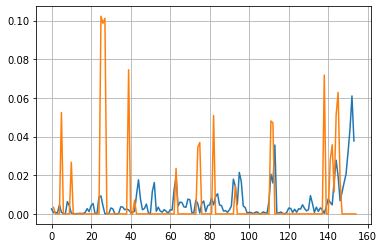

In [6]:
plt.plot(estimate)
n = 0
print(data_cols[n])
plt.plot(df[data_cols[n]])
plt.grid()
# blue shows the vector 'proportion' in the spreadsheet - here it's called estimate
# orange is the first sample amplicon proportions. 

In [7]:
df.head()

,RAW COUNTS,Sample_A100_highconc_rep2_N-3_A100_highconc_rep2_N_AACTTAATAC-AGAGATGAAT_L001\n,Sample_A99_highconc_rep1_N-3_A99_highconc_rep1_N_GATGCTACGA-TTCTCTCCAG_L001\n,Sample_A99_highconc_rep2_N-3_A99_highconc_rep2_N_GATAGTACTA-AGAGGCCGGC_L001\n,Sample_A95_highconc_rep1_N-3_A95_highconc_rep1_N_TATAGGCCAA-CAAGCTCAGG_L001\n,Sample_A95_highconc_rep2_N-3_A95_highconc_rep2_N_GAATAGACGC-CGCTTCAATT_L001\n,Sample_A90_highconc_rep1_N-3_A90_highconc_rep1_N_ACGTCGATTC-ATAGGTCCAA_L001\n,Sample_A90_highconc_rep2_N-3_A90_highconc_rep2_N_ATCCAAGTTG-CGTACCAACG_L001\n,Sample_A80_highconc_rep1_N-3_A80_highconc_rep1_N_TGCCTTCCTA-TGCTGCCGGA_L001\n,Sample_A80_highconc_rep2_N-3_A80_highconc_rep2_N_TTACCGTTCA-GTCCGTAGAT_L001\n,...,Sample_Bangor_5009_E1-3_Bangor_5009_E1_ACGAGAATCA-CGGCGCTCAA_L001\n,Sample_Bangor_5003_F1-3_Bangor_5003_F1_AGACGACTCC-CCTACTCAAC_L001\n,Sample_cont_pos_H10-3_cont_pos_H10_TTCTGCTTCT-GACGCTGCAT_L001\n,Sample_Ldn_140121_2_cond2_rep1_N-3_Ldn_140121_2_cond2_rep1_N_GCCAGCGCCG-GCTGGTTATA_L001\n,Total,Grand_total (values),proportion (formula),proportion (est.) (formula),normalised_proportion,proportion (normalized) (values)
1,1.0,0.003377,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,10800.0,0.003012,0.002588,0.002573,0.002569,0.002569
2,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,2740.0,0.000764,0.000656,0.000653,0.000652,0.000652
3,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,3200.0,0.000892,0.000767,0.000763,0.000763,0.000763
4,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,2170.0,0.000605,0.000521,0.000518,0.000518,0.000518
5,5.0,0.052474,0.017947,0.032324,0.041786,0.033041,0.0,0.036852,0.023311,0.028701,...,0.0,0.0,0.0,0.0,19400.0,0.005410,0.004652,0.004682,0.004676,0.004676


In [8]:
distributions = np.array(df[data_cols])

In [9]:
len_est, len_dists = np.shape(distributions)
print(np.shape(distributions))

(154, 50)


In [10]:
distances = (distributions - np.multiply(estimate.reshape(len_est, 1), np.ones((1, len_dists)))) ** 2
distances = distances.mean(axis=1).astype(float)

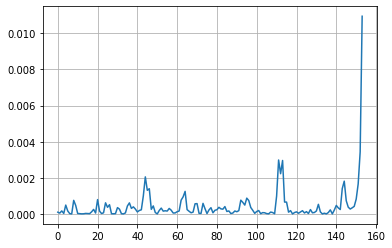

In [11]:
plt.plot(distances)
plt.grid()
# for each amplicon calculate the RMS deviation from the 'estimate' vector

Note about Dirichlet distribution (from Wikipedia). 

$$Var(p_i) = \frac{\tilde{\alpha_i} (1 - \tilde{\alpha_i})}{\alpha_0 + 1}$$

where $\alpha_0 = \Sigma_i \alpha_i$ and $\tilde{\alpha_i} = \alpha_i/\alpha_0$. 

The 'distances' that I've calculated are 

$$ d_i = (1/N) \times \Sigma_{j=1}^N (p_{ij} - \alpha_i)^2 $$ - i.e. exactly the variances for each amplicon (indexed by j) across all of the samples. 

So to try to match these two things up... 

$$\alpha_0 = \tilde{\alpha_i} (1 - \tilde{\alpha_i})/ d_i - 1$$

$\alpha_0$ (name taken from wikipedia) is the same as what we've called $c$ elsewhere. 

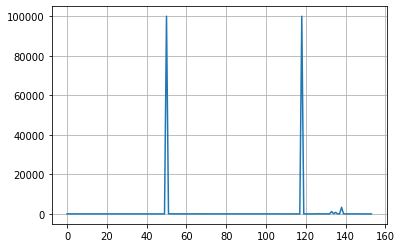

In [12]:
a_0_estimates = (estimate * (1 - estimate) / distances) - 1
plt.plot(a_0_estimates)
plt.grid()
# A few amplicons (21 for example) require an extremely large value of c, but most do not. 
# I think this is an amplicon that generally doesn't do well (often drops out). 

In [13]:
# these values below are intended to exclude some of the larger peaks seen above, and produce a value of c from
# the remaining amplicons. 
print(np.mean([x for x in a_0_estimates if x < 100]))
print(np.mean([x for x in a_0_estimates if x < 200]))
print(np.mean([x for x in a_0_estimates if x < 300]))
print(np.mean([x for x in a_0_estimates if x < 400]))
print(np.mean([x for x in a_0_estimates if x < 500]))
print(np.mean([x for x in a_0_estimates if x < 1000]))
print(np.mean([x for x in a_0_estimates if x < 5000]))

16.99707288040944
17.608924111199066
17.608924111199066
17.608924111199066
17.608924111199066
22.692702333583078
52.19310971765264


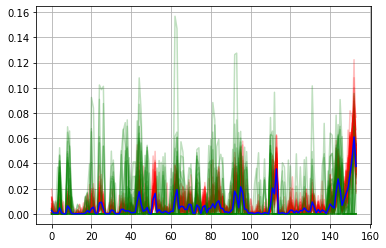

In [14]:
# In the code below we are drawing from the distribution Dirichlet(alpha * c), and comparing some of the real
# distributions (green) with the simulated distributions (red) drawn from the Dirichlet distribution. 
c = 261.0
for i in range(55):
    plt.plot(dirichlet(estimate * c), color="r", alpha=0.25) #this alpha means how 'transparent' the image is

distributions2 = np.array(df[high_conc])
plt.plot(distributions2, color="g", alpha=0.25)
plt.plot(estimate, color="b")
plt.grid()
# blue is the hyperparameter 'estiamte'
# green and the highconc values 
# red are sampled from the dirichlet with c = 261

In my opinion, to get roughly the right amount of variation for the highconc samples, you should use a c value of about 260 whereas to get roughly the right amount of variation for the highconc and lowconc samples combined (probably not recommended) you should use a value of c more like 10. 

Other way of doing a similar / analogous computation is what Nick suggested - will try this below:

In [15]:
distances_samples = (distributions - np.multiply(estimate.reshape(len_est, 1), np.ones((1, len_dists))))** 2
distances_samples = distances_samples.mean(axis=0).astype(float)

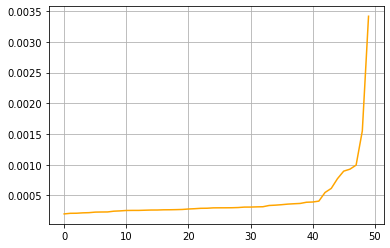

In [16]:
distances_samples.sort()
plt.plot(distances_samples, color="orange")
plt.grid()

I think this gives pretty similar results which is reassuring - most of the really large values in the orange plot above come from samples that just aren't at all well modelled by the dirichlet estimate, whereas for the 'highconc' samples (mainly the points closer to the origin) the var/$l_2$ distance is in the range 0.0001 or less, and the corresponding value for c is something like in the 100-200 range. 

In [21]:
# Note: the above analysis looks at rms distances, whereas a different analysis Nick did, looking at
# certain amplicons which often were sampled with 0 samples (e.g. amplicon 21) is a sort of worst-case
# analysis. That produced an answer for c as more like 10,000. 

estimate

array([2.57946878e-03, 6.61873685e-04, 7.72544492e-04, 5.27686822e-04,
       4.68633596e-03, 8.55291470e-04, 9.65352787e-05, 7.08987259e-05,
       6.37598970e-03, 4.20708015e-03, 4.12274682e-04, 1.82260481e-04,
       9.50580796e-05, 1.96341524e-04, 2.54452632e-04, 2.62886963e-04,
       1.97413685e-04, 7.32278903e-04, 2.74896547e-03, 1.20310039e-03,
       4.30395582e-03, 5.37432955e-03, 2.15140074e-04, 1.91457236e-04,
       8.81772840e-03, 9.28652470e-03, 4.27634173e-03, 1.09734768e-04,
       1.04469595e-04, 1.75827516e-04, 3.06217933e-03, 2.65023138e-03,
       1.30582336e-04, 4.95269899e-05, 2.87832568e-04, 3.69585011e-03,
       3.54469929e-03, 2.18195925e-03, 2.54587441e-03, 2.04100586e-03,
       9.20431186e-04, 9.79709759e-04, 1.30345463e-03, 9.98099890e-03,
       1.76499021e-02, 7.61338224e-03, 2.13628521e-03, 2.81024540e-03,
       5.09416206e-03, 5.31832509e-04, 1.00000000e-05, 1.16279078e-02,
       1.62527193e-02, 1.36454396e-03, 3.47736760e-03, 1.45755986e-03,
      

In [22]:
# uncomment this to create the hyperparameter file 
#with open("amplicon_prior.csv", "w") as f:
#    f.write("amplicon_number,hyperparameter\n")
#    for i, e in enumerate(estimate):
#        f.write(f"{i+1},{e}\n")

In [23]:
# the following plot is looking at a PCA plot of the various datasets
# the PCA axes used are taken from all of the real distributions. 

high_conc_indices =  [i for i, x in enumerate(data_cols) if x.split("_")[2] == "highconc" or x.split("_")[2] == "pos"]
low_conc_indices =  [i for i, x in enumerate(data_cols) if x.split("_")[2] == "lowconc"]
ldn_indices = [i for i, x in enumerate(data_cols) if x.split("_")[1] == "Ldn"]
print(high_conc_indices)
print(low_conc_indices)
print(ldn_indices)

pca = PCA(n_components=2)
transformer = pca.fit(distributions.T)
d = transformer.transform(distributions.T)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 48]
[20, 21, 22, 23, 24]
[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 49]


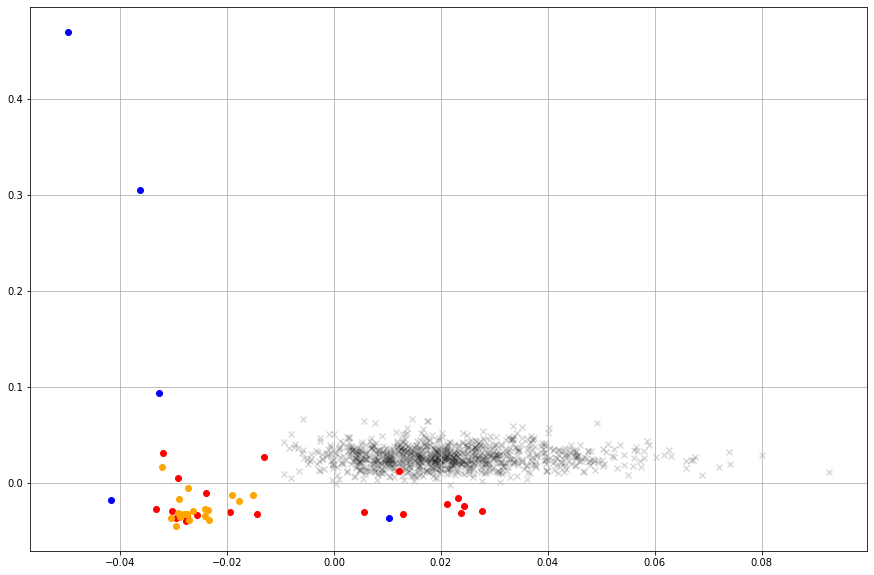

In [24]:
e = transformer.transform(dirichlet(220*estimate, size=1000))
plt.figure(figsize=(15, 10))
plt.scatter(e[:, 0], e[:, 1], marker="x", color="black", alpha=0.15)
plt.scatter(d[high_conc_indices, 0], d[high_conc_indices, 1], color="red")
plt.scatter(d[low_conc_indices, 0], d[low_conc_indices, 1], color="blue")
plt.scatter(d[ldn_indices, 0], d[ldn_indices, 1], color="orange")

plt.grid()